# Dogs vs. CatsをCNNで解く

## パッケージのインポート

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import seaborn as sns

## トレーニング・テストデータの作成

In [3]:
# ディレクトリの設定
TRAIN_DIR = "./train/"
TEST_DIR = "./test/"

In [4]:
# パラメータの設定
ROWS = 244
COLS = 244
CHANNELS = 3

## 画像ファイルをNumpy配列（多次元配列）に変換する

In [5]:
# 画像の読み込み関数
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

# データ準備関数
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
    return data

## 訓練データとテストデータを抽出

In [6]:
# 画像ファイルのリスト取得
train_images = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]
train_dogs = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if "dog" in i]
train_cats = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if "cat" in i]
test_images = [TEST_DIR + i for i in os.listdir(TEST_DIR)]

# データの準備
train = prep_data(train_images)
test = prep_data(test_images)

## ラベル一覧をリスト型変数に格納する

In [7]:
# ラベルの設定
labels = [1 if 'dog.' in i else 0 for i in train_images]
labels = np.array(labels)

Text(0.5, 1.0, 'Cats and Dogs TRAIN')

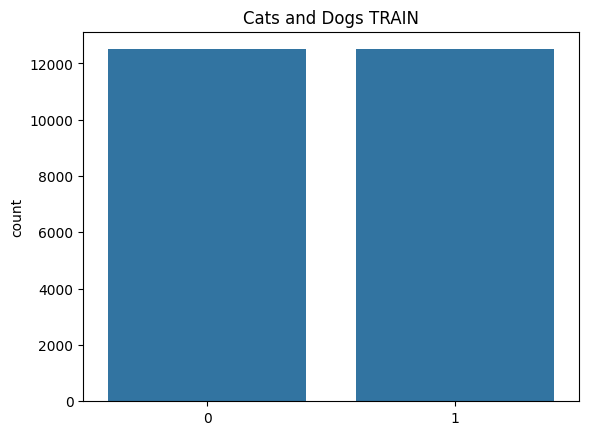

In [8]:
sns.countplot(x=labels)
plt.title('Cats and Dogs TRAIN')

## 画像データの確認

In [9]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

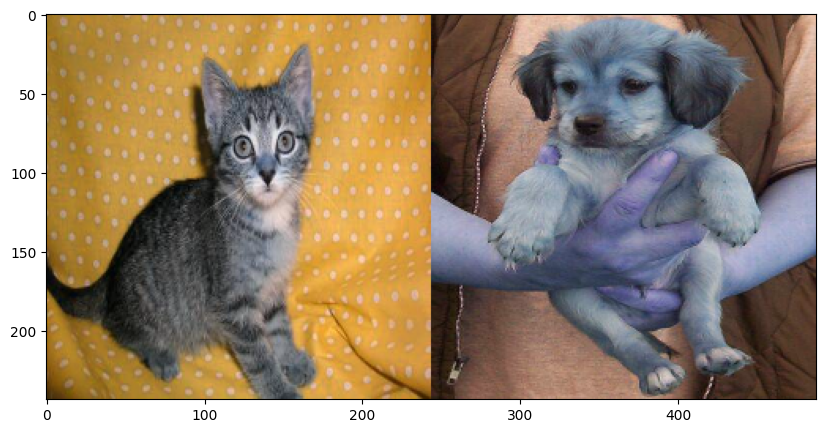

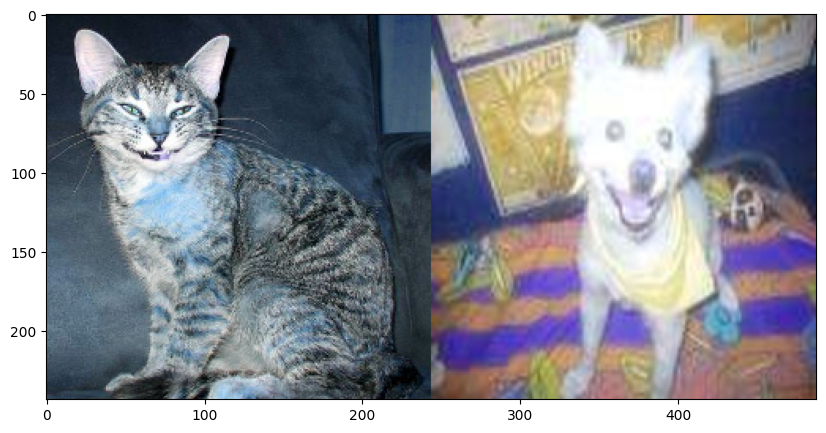

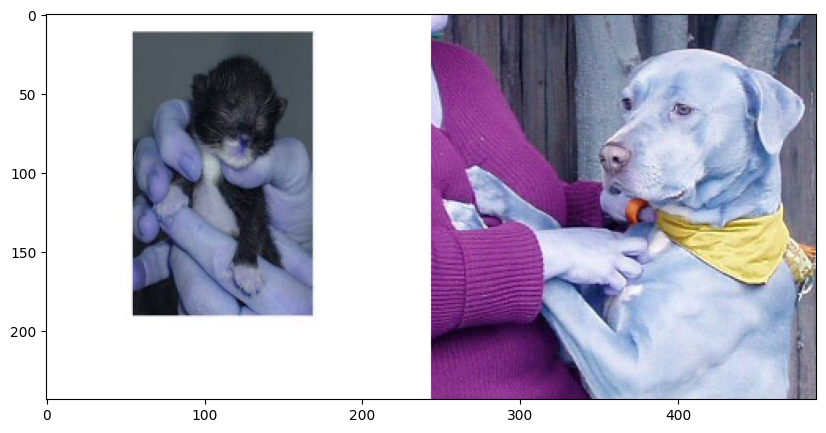

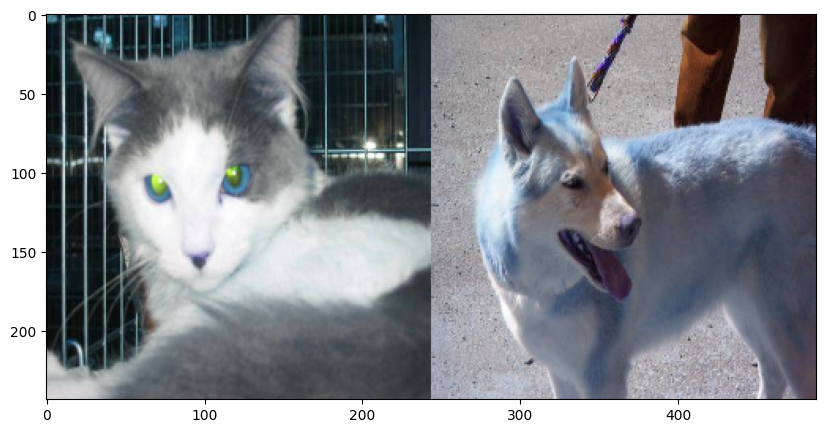

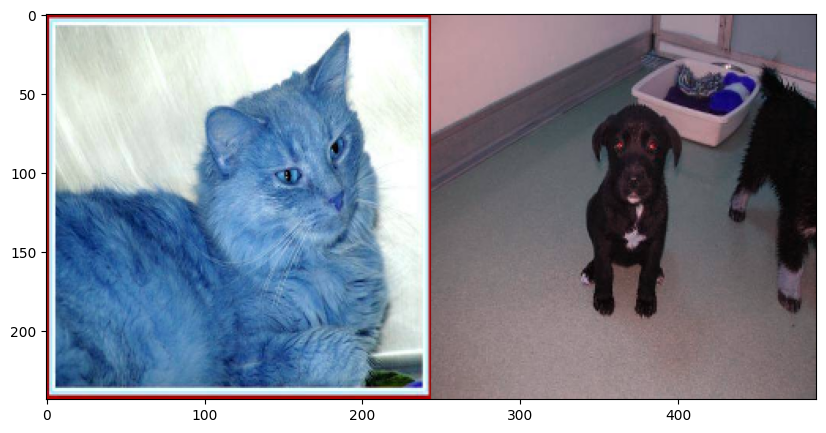

In [10]:
for idx in range(0,5):
    show_cats_and_dogs(idx)

## 画像前処理

In [11]:
# ImageDataGeneratorの設定
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)

train_generator = datagen.flow(train, labels, batch_size=32, subset='training')
validation_generator = datagen.flow(train, labels, batch_size=32, subset='validation')

## モデルを定義（VGG16を導入）

In [12]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPool2D, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [13]:
# VGG16モデルの導入
vgg16 = VGG16(weights='imagenet', include_top=False, pooling="avg", input_shape=(ROWS, COLS, CHANNELS))
vgg16.trainable = False  # 事前訓練済み層を凍結

# モデルの構築
def catdog():
    model = models.Sequential()
    model.add(vgg16)
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

model = catdog()


2024-07-12 16:00:00.412179: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-12 16:00:00.414488: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-12 16:00:00.414496: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-12 16:00:00.415716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-12 16:00:00.417923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## トレーニングを実行

In [ ]:
# モデルのコンパイル
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 途中経過(loss値)を確認するためのクラス
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# コールバックの設定
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = LossHistory()

# モデルの訓練
epochs = 5
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[early_stopping, history])

# テストデータの予測
test = test / 255.0  # テストデータのスケーリング
predictions = model.predict(test, verbose=1)

Epoch 1/5


2024-07-12 16:00:05.406698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


556/586 ━━━━━━━━━━━━━━━━━━━━ 3:27 7s/step - accuracy: 0.8302 - loss: 0.3573

## 収束状況（loss）を可視化

In [ ]:
# 結果の表示
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## 推定結果を可視化

In [ ]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5:
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else:
        print('I am {:.2%} sure this is a Cat'.format(1 - predictions[i][0]))

    plt.imshow(test[i])
    plt.show()